In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np

device = torch.device("mps")

In [3]:
# simple tokenization by characters

lines = open('./input.txt', 'r').read()

vocab = list(set(lines))
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}

def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])

print('vocab size:', len(vocab))

vocab size: 65


In [4]:
dataset = torch.tensor(encode(lines), dtype=torch.int8)
dataset

tensor([31, 21, 22,  ...,  8, 46, 54], dtype=torch.int8)

In [5]:
config = {
    "d_model": 100,
    "vocab_size": len(vocab),
    'batch_size': 32,
    'context_window': 10,
}


def get_batches(data, split, batch_size, context_window):
    train, val, test = data[:int(.8 * len(data))], data[int(.8 * len(data)): int(.9 * len(data))], data[int(.9 * len(data)):]
    
    if split == 'train':
        data = train
    elif split == 'val':
        data = val
    
    xs = torch.zeros(batch_size, context_window, dtype=torch.long)
    ys = torch.zeros(batch_size, context_window, dtype=torch.long)

    # pick random starting points
    starts = torch.randint(0, len(data) - context_window - 1, (batch_size,))
    for item, start in enumerate(starts):
        
        xs[item] += data[start:start+context_window]
        ys[item] += data[start+1:start+context_window+1]
    return xs, ys
    
xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])

In [6]:
class MaskedRotarySelfAttentionHead(nn.Module):
    """
    Rotary embeddings.

    Input: (BATCH_SIZE x CONTEXT_WINDOW)
    Output: (BATCH_SIZE x CONTEXT_WINDOW x EMBEDDING_DIM)
    """
    def __init__(self, config):
        super().__init__()
        self.config = config

        if config['d_model'] % 2 != 0:
            raise ValueError("d_model must be divisible by 2")
        self.w_q = torch.randn(config['d_model'], config['d_model'], requires_grad=True)
        self.w_k = torch.randn(config['d_model'], config['d_model'], requires_grad=True)
        self.w_v = torch.randn(config['d_model'], config['d_model'], requires_grad=True)
        self.register_buffer("tril", torch.tril(torch.ones(config['context_window'], config['context_window']))) # mask
        
    def get_rotary_matrix(self, x):
        b, m, d = x.shape
        R = torch.zeros((d, d, m))
        for position in range(m):
            for i in range(d//2):
                theta = 10000. ** (-2.*(i - 1) / d)
                m_theta = position * theta
                R[2*i,2*i, position] = np.cos(m_theta)
                R[2*i,2*i+1, position] = - np.sin(m_theta)
                R[2*i+1,2*i, position] = np.sin(m_theta)
                R[2*i+1,2*i+1, position] = np.cos(m_theta)
        return R

    def forward(self, x):
        """
        x: [BATCH_SIZE x CONTEXT_WINDOW x EMBEDDING_DIM]
        out: [BATCH_SIZE x CONTEXT_WINDOW x EMBEDDING_DIM]
        """
        b, m, d = x.shape
        R = self.get_rotary_matrix(x) # [d x d x m]

        q_rotated_query_weight = self.w_q @ R # [d x d x m]
        q = q_rotated_query_weight.view(m, d, d) @ x.view(m, d, b)
        q = q.view(b, m, d)

        k_rotated_query_weight = self.w_k @ R # [d x d x m]
        k = k_rotated_query_weight.view(m, d, d) @ x.view(m, d, b)
        k = k.view(b, m, d)
        
        B = (q @ k.transpose(1,2)) / np.sqrt(self.config['d_model'])
        mask = B.masked_fill(self.tril[:m, :m] == 0, float("-inf"))
        a = F.softmax(mask, dim=-1) # attention
        v = x @ self.w_v 
        out = a @ v
        return out


config = {
    "batch_size": 3,
    "context_window": 10,
    "d_model": 128,
}
r = MaskedRotarySelfAttentionHead(config)
batch = torch.randn((3, 10, config['d_model']))

r(batch).shape

torch.Size([3, 10, 128])

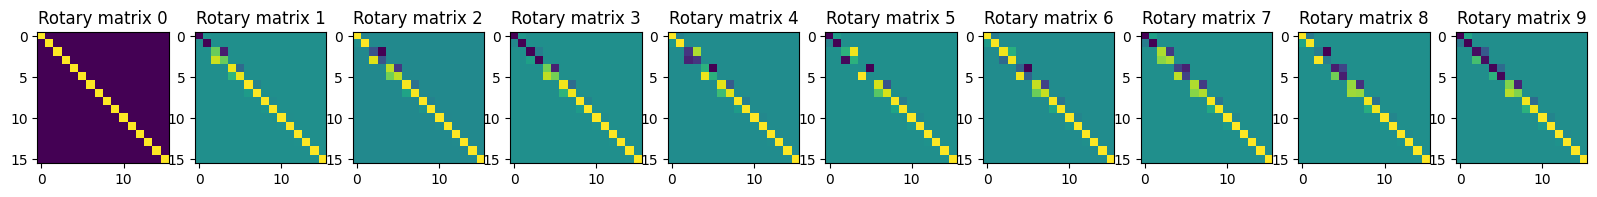

In [7]:
config = {
    "batch_size": 3,
    "context_window": 10,
    "d_model": 16,
}
r = MaskedRotarySelfAttentionHead(config)
batch = torch.randn((3, 10, config['d_model']))

R = r.get_rotary_matrix(batch)
fix, ax = plt.subplots(1, R.shape[-1], figsize=(20, 5))
for i in range(R.shape[-1]):
    ax[i].imshow(R[:, :, i].detach().numpy())
    ax[i].set_title(f'Rotary matrix {i}')

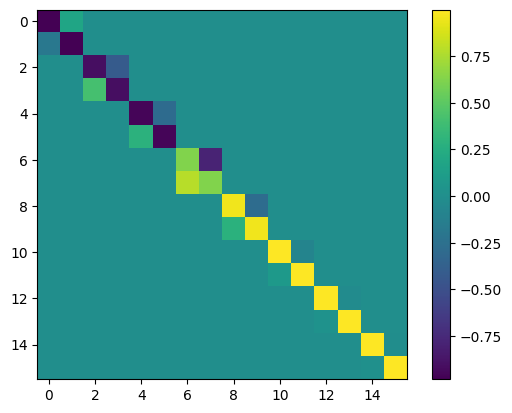

In [8]:
config = {
    "batch_size": 3,
    "context_window": 10,
    "d_model": 16,
}
r = MaskedRotarySelfAttentionHead(config)
batch = torch.randn((3, 10, config['d_model']))

R = r.get_rotary_matrix(batch)
plt.imshow(R[...,-1].detach().numpy())
plt.colorbar()

In [9]:
config = {
    "batch_size": 1,
    "context_window": 10,
    "d_model": 16,
}
r = MaskedRotarySelfAttentionHead(config)
batch = torch.randn((1, 10, config['d_model']))

R = r.get_rotary_matrix(batch)
b, m, d = batch.shape

q_rotated_query_weight = r.w_q @ R # [d x d x m]
q = q_rotated_query_weight.view(m, d, d) @ batch.view(m, d, b)
q = q.view(b, m, d)

k_rotated_query_weight = r.w_k @ R # [d x d x m]
k = k_rotated_query_weight.view(m, d, d) @ batch.view(m, d, b)
k = k.view(b, m, d)

B = (q @ k.transpose(1,2)) / np.sqrt(r.config['d_model'])
mask = B.masked_fill(r.tril[:m, :m] == 0, float("-inf"))
a = F.softmax(mask, dim=-1) # attention
v = batch @ r.w_v 
out = a @ v

In [10]:
class MaskedRotaryNultiHeadedAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList([
            MaskedRotarySelfAttentionHead(config) for _ in range(config["n_heads"])
        ])
        self.linear = nn.Linear(config["n_heads"] * config["d_model"], config["d_model"])
        self.dropout = nn.Dropout(0.1)


    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        out = self.dropout(self.linear(out))
        return out

config = {
    "n_heads": 8,
    "d_model": 128,
    "batch_size": 32,
    "context_window": 16,
}

batch = torch.randn((1, 1, config['d_model']))
m = MaskedRotaryNultiHeadedAttention(config)

m(batch).shape

torch.Size([1, 1, 128])

In [11]:
class SwiGLU(nn.Module):
    """
    Swish-Gated Linear Unit
    https://arxiv.org/pdf/2002.05202v1.pdf
    """
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.linear_gate = nn.Linear(config['d_model'], config['d_model'])
        self.linear = nn.Linear(config['d_model'], config['d_model'])
        self.beta = torch.randn(1, requires_grad=True)

    def forward(self, x): 
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out

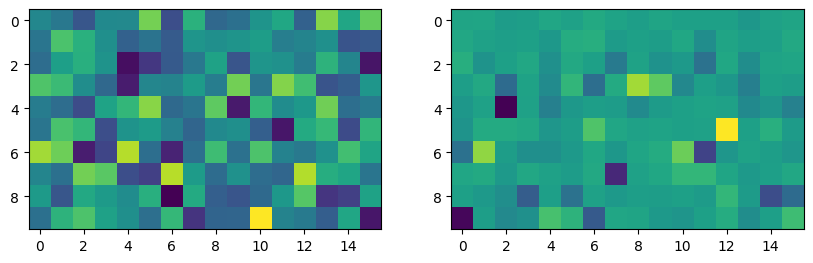

In [12]:
config = {
    "n_heads": 8,
    "d_model": 16,
    "batch_size": 3,
    "context_window": 10,
}
s = SwiGLU(config)
batch = torch.randn(config['batch_size'], config['context_window'], config["d_model"])
out = s(batch)
out.shape
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(batch[0].detach().numpy())
ax[1].imshow(out[0].detach().numpy())

In [13]:
class RMSNorm(nn.Module):
    def __init__(self, d, p=-1., eps=1e-8, bias=False):
        """
            Root Mean Square Layer Normalization
        :param d: model size
        :param p: partial RMSNorm, valid value [0, 1], default -1.0 (disabled)
        :param eps:  epsilon value, default 1e-8
        :param bias: whether use bias term for RMSNorm, disabled by
            default because RMSNorm doesn't enforce re-centering invariance.

        https://github.com/bzhangGo/rmsnorm/blob/master/rmsnorm_torch.py
        """
        super(RMSNorm, self).__init__()

        self.eps = eps
        self.d = d
        self.p = p
        self.bias = bias

        self.scale = nn.Parameter(torch.ones(d))
        self.register_parameter("scale", self.scale)

        if self.bias:
            self.offset = nn.Parameter(torch.zeros(d))
            self.register_parameter("offset", self.offset)

    def forward(self, x):
        if self.p < 0. or self.p > 1.:
            norm_x = x.norm(2, dim=-1, keepdim=True)
            d_x = self.d
        else:
            partial_size = int(self.d * self.p)
            partial_x, _ = torch.split(x, [partial_size, self.d - partial_size], dim=-1)

            norm_x = partial_x.norm(2, dim=-1, keepdim=True)
            d_x = partial_size

        rms_x = norm_x * d_x ** (-1. / 2)
        x_normed = x / (rms_x + self.eps)

        if self.bias:
            return self.scale * x_normed + self.offset

        return self.scale * x_normed

In [14]:
config = {
    "n_heads": 8,
    "d_model": 512,
    "batch_size": 3,
    "context_window": 10,
}

class LlamaLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.multihead = nn.Sequential(
            RMSNorm(config['d_model']),
            MaskedRotaryNultiHeadedAttention(config)
        )
        self.ffn = nn.Sequential(
            RMSNorm(config['d_model']),
            SwiGLU(config),
        )

    def forward(self, x):
        mid = x + self.multihead(x)
        out = mid + self.ffn(mid)

        return out

batch = torch.randn((1, 1, config['d_model']))
m = LlamaLayer(config)
m(batch).shape

torch.Size([1, 1, 512])

In [15]:
from collections import OrderedDict

class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Linear(config['d_model'], config['vocab_size'])
        self.layers = nn.Sequential(OrderedDict([
            (f"llama_layer_{i}", LlamaLayer(config)) for i in range(config['n_layers'])
        ]))

    def forward(self, idx, targets=None):
        """
        idx: [batch_size, seq_len]
        targets: [batch_size, seq_len]
        """

        # logits = x # todo
        embeds = self.embedding(idx) # [batch_size, seq_len, hidden_size]
        logits = self.layers(embeds) # [batch_size, seq_len, d_model]
        logits = F.softmax(self.linear(logits), dim=-1) # [batch_size, seq_len, vocab_size]

        if targets is None:
            return logits
        
        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

    def generate(self, idx, max_len=20):
        """
        idx: [batch_size, seq_len]
        """
        for i in range(max_len):
            logits = self(idx[:, -self.config['context_window']:])
            pred = torch.argmax(logits, dim=-1)[..., -1:]
            idx = torch.cat([idx, pred], dim=-1)

        return idx

In [16]:
import time

config = {
    "n_heads": 8,
    "d_model": 128,
    "batch_size": 32,
    "n_layers": 4,
    "context_window": 16,
    "vocab_size": len(vocab),
    "epochs": 1000,
    "log_interval": 10,
}

model = Llama(config)
sum([p.numel() for p in model.parameters()])


674625

In [17]:
from matplotlib import pyplot as plt

@torch.no_grad()  # don't compute gradients for this function
def evaluate_loss():
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

# train
optimizer = torch.optim.Adam(
    model.parameters(), 
    betas=(.9, .95), 
    weight_decay=.1, 
    eps=1e-9, 
    lr=3e-4
)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 300, eta_min=1e-5)

start_time = time.time()
losses = []

for epoch in range(config['epochs']):
    optimizer.zero_grad()
    
    xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
    logits, loss = model(xs, targets=ys)
    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    # scheduler.step()

    if epoch % config['log_interval'] == 0:
        batch_time = time.time() - start_time
        losses += [evaluate_loss()]
        print(f"Epoch {epoch} | Loss {loss.item():.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
        start_time = time.time()

        # examples = model.generate(torch.arange(0, 4).unsqueeze(1))
        # for e in examples.detach().numpy():
        #     print(decode(list(e)))

        # inspecting to make sure no gradients are exploding
        # for name, param in model.named_parameters():
        #     if param.requires_grad:
        #         if param.grad is not None:
        #             print(f"{name} | grad norm {param.grad.norm().item():.3f} | param norm {param.norm().item():.3f}")


Epoch 0 | Loss 4.176 | Time 0.801 | ETA in seconds 80.059
Epoch 10 | Loss 4.184 | Time 7.549 | ETA in seconds 747.330


KeyboardInterrupt: 

In [ ]:
for name, p in model.named_parameters():
    print(name)

embedding.weight
linear.weight
linear.bias
layers.llama_layer_0.prenorm.weight
layers.llama_layer_0.prenorm.bias
layers.llama_layer_0.multihead.linear.weight
layers.llama_layer_0.multihead.linear.bias
layers.llama_layer_0.ffn.0.weight
layers.llama_layer_0.ffn.0.bias
layers.llama_layer_0.ffn.1.linear_gate.weight
layers.llama_layer_0.ffn.1.linear_gate.bias
layers.llama_layer_0.ffn.1.linear.weight
layers.llama_layer_0.ffn.1.linear.bias
layers.llama_layer_0.postnorm.weight
layers.llama_layer_0.postnorm.bias
layers.llama_layer_1.prenorm.weight
layers.llama_layer_1.prenorm.bias
layers.llama_layer_1.multihead.linear.weight
layers.llama_layer_1.multihead.linear.bias
layers.llama_layer_1.ffn.0.weight
layers.llama_layer_1.ffn.0.bias
layers.llama_layer_1.ffn.1.linear_gate.weight
layers.llama_layer_1.ffn.1.linear_gate.bias
layers.llama_layer_1.ffn.1.linear.weight
layers.llama_layer_1.ffn.1.linear.bias
layers.llama_layer_1.postnorm.weight
layers.llama_layer_1.postnorm.bias
layers.llama_layer_2.pren